### Time Series Analysis : ARIMA

In [1]:
import pandas as pd
import math
import numpy as np
import calendar
import seaborn as sns
import itertools
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline  
import warnings
warnings.filterwarnings("ignore")
plt.style.use('ggplot')

The dataset used in this tutorial is from Kaggle, here is the link: https://www.kaggle.com/rakannimer/air-passengers

In [2]:
passenger_data = pd.read_csv('AirPassengers.csv')
passenger_data.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


Let's convert the Month column into datetime format.

In [3]:
passenger_data.Month = pd.to_datetime(passenger_data.Month, 
                                      infer_datetime_format=True)
passenger_data.head()

,Month,#Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [4]:
# Check for missing data
passenger_data['#Passengers'].isnull().sum()

0

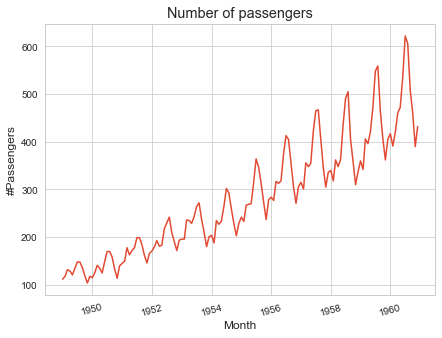

In [5]:
# Time series visulizatioin 
plt.figure(figsize=(7, 5))
sns.set_style("whitegrid")
sns.lineplot(x="Month", y="#Passengers", data=passenger_data)
plt.xticks(rotation=15)
plt.title('Number of passengers')
plt.show()

We can notice some features are evident on this graph:
* Overall there is a very strong upward trend, which is due to the growth of economy.
* There is a very pronounced seasonal pattern.
* The amplitude of the seasonal variation has grown over time.

A forecasting model for this time series must accommodate all these qualitative features, and ideally it should shed light on their underlying causes. To study these features of the time series in more depth, and to help determine which kind of forecasting model is most appropriate, we should next plot some transformations of the original data.

A common assumption in many time series techniques is that the data are stationary. It does not mean that the time series does not change over time. It is just the way it changes does not change over time, meaning the mean, variance and autocorrelation structure of the time series do not change over time. In this tutorial we will use ARIMA model to predict the future number of passengers. To make sure ARIMA is suitable for our case, we need to do some Exploratory Data Analysis (EDA) first.

There are 4 components of time series:
 * **Trend** - Upward & downward movement of the data with time over a long period of time
 > The trend shows the long term tendency of the data. A trend is a smooth, general, long-term, average tendency. There are upward, downward or stable (linear trend) and non-linear trend.
 * **Seasonality** - Periodic pattern. Eq: Ice cream sales increases in Summer only
 > A seasonal pattern exists when a series is influenced by seasonal factors (e.g., the quarter of the year, the month, or day of the week). Seasonality is always of a fixed and known period. Hence, seasonal time series are sometimes called periodic time series.
 * **Cyclicity** - Behavior that repeats itself after large interval of time
 > A cyclic pattern exists when data exhibit rises and falls that are not of fixed period. The duration of these fluctuations is usually more than one year. One complete period is a cycle. Take the business cycle as an example, there are a four-phase cycle comprising of the phases of prosperity, recession, depression, and recovery. We don't know how long the current cycle gonna last. 
 * **Random or Irregular movements** - Spikes & troughs at random intervals


### Transformations of time series using Python

In many situations, it is desirable or necessary to transform a time series
data before using the sophisticated models because:
* Almost all methods assume that the amount of variability in a time
series is constant across time.
* Many times we would like to study what is left in a data set after
having removed trends or cycles in the data.

**Note**: After choosing a transformation, we will forecast the transformed data. Then, we need to reverse the transformation (or back-transform) to obtain forecasts on the original scale.

**1. Power Transformation: $\color{red}{\text{stabilize the variance}}$**

A simple but effective way to stabilize the variance across time is to
apply a power transformation (square root, cube root, log, etc) to the time series.

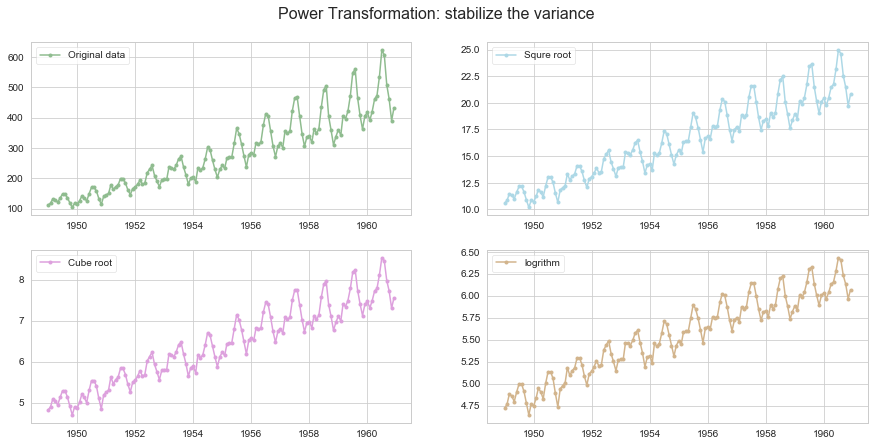

In [27]:
x = passenger_data.Month
y = passenger_data['#Passengers']           # Original
y1 = np.sqrt(passenger_data['#Passengers']) # Squre root
y2 = passenger_data['#Passengers']**(1/3)   # Cube root
y3 = np.log(passenger_data['#Passengers'])  # log 

y = {'Original data': y,
     'Squre root': y1, 
     'Cube root': y2, 
     'logrithm': y3}

colors = ['darkseagreen', 'lightblue', 'plum', 'tan']

plt.figure(figsize=(15,7))
n = math.ceil(len(y)/2)

for i, (key, value) in enumerate(y.items()):
    plt.subplot(n, 2, i+1)
    plt.plot(x, value, '.-', label=key, color=colors[i])
    plt.legend()

plt.suptitle('Power Transformation: stabilize the variance',  y=0.95, fontsize=16)
plt.show()

**2. Dividing Seasonal Standard Deviations**

Sometimes with data observed periodically (hourly, daily, monthly, etc),
the variability may vary for different periods; for example, there may be
more variability on mondays than on tuesdays, and so on. When this
happens, it is often useful to calculate the standard deviation for each of
the different periods and then for example, divide each monday by the
standard deviation of all the mondays, the tuesdays by the standard
deviation of the tuesdays, and so on (notice that dividing a set of any
numbers by their standard deviation results in the standard deviation of
the new set of numbers being equal to one)

In [7]:
# Calculate the standard deviation of each year
passenger_data['year'] = passenger_data.Month.dt.year
yearly_std = pd.DataFrame(passenger_data.groupby('year')['#Passengers'].apply(np.std))
yearly_std.columns = ['yearly_std']
merged = pd.merge(passenger_data, yearly_std, left_on='year', right_index=True)
merged.head()

,Month,#Passengers,year,yearly_std
0,1949-01-01,112,1949,13.13604
1,1949-02-01,118,1949,13.13604
2,1949-03-01,132,1949,13.13604
3,1949-04-01,129,1949,13.13604
4,1949-05-01,121,1949,13.13604


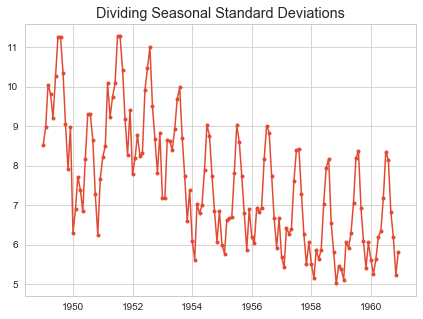

In [9]:
y_remove_seasonal_std = merged['#Passengers']/merged['yearly_std']
plt.figure(figsize=(7, 5))
plt.plot(x, y_remove_seasonal_std, '.-')
plt.title('Dividing Seasonal Standard Deviations')
plt.show()

**3. Subtracting Seasonal Means**

One way to remove cycles in data observed periodically is to calculate
the sample means of each of the periods (hours or days, for example)
and then subtract them from the correpsonding period (subtract the
mean of the mondays from mondays, that of tuesdays from each
tuesday, and so on).

In [10]:
yearly_mean = pd.DataFrame(passenger_data.groupby('year')['#Passengers'].apply(np.mean))
yearly_mean.columns = ['yearly_mean']
merged_2 = pd.merge(passenger_data, yearly_mean, left_on='year', right_index=True)
merged_2.head()

,Month,#Passengers,year,yearly_mean
0,1949-01-01,112,1949,126.666667
1,1949-02-01,118,1949,126.666667
2,1949-03-01,132,1949,126.666667
3,1949-04-01,129,1949,126.666667
4,1949-05-01,121,1949,126.666667


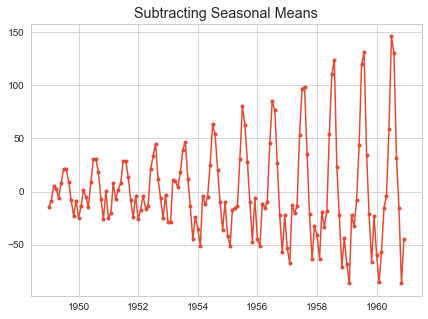

In [11]:
y_subtract_seasonal_mean = merged_2['#Passengers'] - merged_2['yearly_mean']
plt.figure(figsize=(7, 5))
plt.plot(x, y_subtract_seasonal_mean, '.-')
plt.title('Subtracting Seasonal Means')
plt.show()

**4. Differencing: $\color{red}{\text{eliminate trend and seasonality}}$**

Differencing is a popular and widely used data transform for making time series data stationary. Transformations such as logarithms can help to stabilise the variance of a time series. Differencing can help stabilise the mean of a time series by removing changes in the level of a time series, and therefore eliminating (or reducing) trend and seasonality.

A seasonal difference is the difference between an observation and the previous observation from the same season. So

$$y'_{t} = y_{t} - y_{t-m}$$

where m = the number of season. These are also called “lag-m differences”, as we subtract the observation after a lag of  m periods.This method works very well in removing trends and cycles. For example, 
* **Differencing to Remove Trends**: First differencing applied to a series with a linear trend eliminates the trend
* **Differencing to Remove Seasonality**: If cycles of length m exist in a series, a m-th difference will remove them

Here is a plot of the airline passenger data along with its log to stabilize the variance, the 1st difference of the log to eliminate the linear trend, and the 12th difference of the 1st difference of the log to eliminate the annual
cycle.

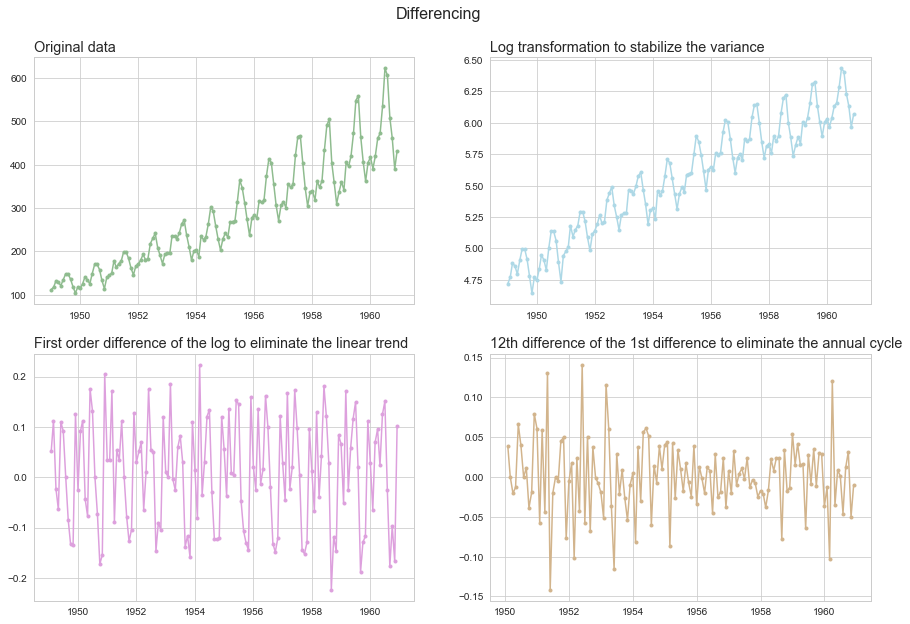

In [29]:
x = passenger_data.Month
y = passenger_data['#Passengers']   # Original
y1 = np.log(y)                      # Log transformation to stabilize the variance
y2 = y1.diff(periods=1)             # First order difference of the log to eliminate the linear trend
y3 = y2.diff(periods=12)            # 12th difference of the 1st difference of the log to eliminate the annual cycle

dic_y = {'Original data': y,
         'Log transformation to stabilize the variance': y1, 
         'First order difference of the log to eliminate the linear trend': y2, 
         '12th difference of the 1st difference to eliminate the annual cycle': y3}
colors = ['darkseagreen', 'lightblue', 'plum', 'tan']

plt.figure(figsize=(15, 10))
n = math.ceil(len(dic_y)/2)

for i, (key, value) in enumerate(dic_y.items()):
    plt.subplot(n, 2, i+1)
    plt.plot(x, value, '.-', color=colors[i])
    plt.title(key, loc='left')

plt.suptitle('Differencing',  y=0.95, fontsize=16)
plt.show()


**5. Regressing on Trends and Cycles**
The natural thing for a statistician to do to eliminate trends and cycles in
a time series would be to regress $x_t$ on linear and/or sinusoidal
functions of t. For example, we could find the residuals from a model
such as:

$$x_t = \beta_0+\beta_1 t+\beta_2 cos(\frac{2π(t−1)}{m})+\beta_3 sin(\frac{2π(t−1)}{m})+\epsilon_t$$

If we felt there was both a linear trend and a sinusoidal cycle of length $m$
in the data. 

The regression would give us an idea of the strength of the linear trend from the coefficients $\hat{\beta}_{1}$ and/or the sinusoid from $\sqrt{\hat{\beta}_{2}^{2} + \hat{\beta}_{3}^2}$


In [45]:
# In our case m = 12 (annual cycle)
reg_data = passenger_data.copy()
reg_data['month_since'] = np.array(range(len(reg_data))) + 1
reg_data['sin'] = np.sin(np.pi*(reg_data['month_since']-1)/6)
reg_data['cos'] = np.cos(np.pi*(reg_data['month_since']-1)/6)
reg_data.head()

,Month,#Passengers,year,month_since,sin,cos
0,1949-01-01,112,1949,1,0.000000,1.000000e+00
1,1949-02-01,118,1949,2,0.500000,8.660254e-01
2,1949-03-01,132,1949,3,0.866025,5.000000e-01
3,1949-04-01,129,1949,4,1.000000,6.123234e-17
4,1949-05-01,121,1949,5,0.866025,-5.000000e-01


In [53]:
from sklearn.linear_model import LinearRegression
X = reg_data[['month_since', 'sin', 'cos']]
y = reg_data['#Passengers']
regressor = LinearRegression()  
regressor.fit(X, y) #training the algorithm

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [57]:
regressor.coef_

array([  2.64987787,   5.42625742, -45.49951906])

In [58]:
regressor.intercept_

88.18246555390752

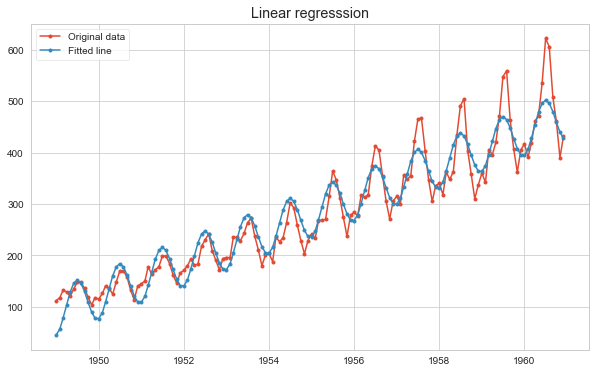

In [61]:
plt.figure(figsize=(10, 6))
plt.plot(x, y, '.-', label='Original data')
plt.plot(x, regressor.predict(X),  '.-', label='Fitted line')
plt.legend()
plt.title('Linear regresssion')
plt.show()

**6. Moving Average Smoother** 
The Smoothed Moving Average (SMA) (or rolling mean) is a series of averages of a time series. It is popular and widely used in finance to smoothen the market noises and show the market trends more clearly. In financial applications a simple moving average is the unweighted mean of the previous $n$ days data. However, in science and engineering, the mean is normally taken from an equal number of data on either side of a central value.

An example of a simple equally weighted running mean for a n-day sample of closing price is the mean of the previous n days' closing prices. If those prices are $x_{M}, x_{M-1},..., x_{M-(n-1)}$then the formula is

$$SMA_{t} = \frac{x_{t} + x_{t-1} +... + x_{t-(n-1)}}{n}$$

The selection of period $n$ depends on the type of movement of interest, such as short, intermediate, or long-term.

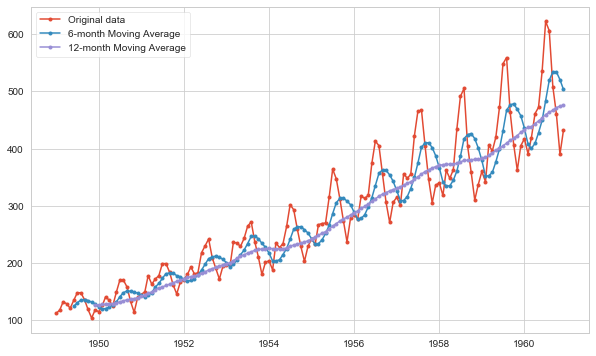

In [32]:
# Calculating the short-window simple moving average
plt.figure(figsize=(10, 6))
plt.plot(x, y, '.-', label='Original data')
plt.plot(x, y.rolling(window=6).mean(), '.-', label='6-month Moving Average')
plt.plot(x, y.rolling(window=12).mean(), '.-', label='12-month Moving Average')
plt.legend()
plt.show()

**7. General Filters**
The MA smoother is a special case of the general idea of using linear smoothers, where new values are the averages of old values centered at the time point of interest. An obvious extension would be to use weights in the MA smoother. The weights would be greater for x’s near the time point t and smaller farther away from t.

Exponential smoothing is a rule of thumb technique for smoothing time series data using the exponential window function. Unlike the simple moving which average the past observations, exponential functions are used to assign exponentially decreasing weights over time.

$$EMA_{t} = \alpha * x_{t} + (1-\alpha)*EMA_{t-1} \\
= \alpha * x_{t} + \alpha * (1-\alpha) * x_{t-1} + (1-\alpha)^2*EMA_{t-2} $$

In other words, as time passes the smoothed statistic $EMA_{t}$ becomes the weighted average of the past observations $x_{t-n}$ where $n=0...(t-1)$, and the weights assigned to previous observations are proportional to the terms of the geometric progression $1, (1 − \alpha), (1 − \alpha)^2, (1 − \alpha)^3, ...$, meaning the farther away the time point is, the lower the weight.

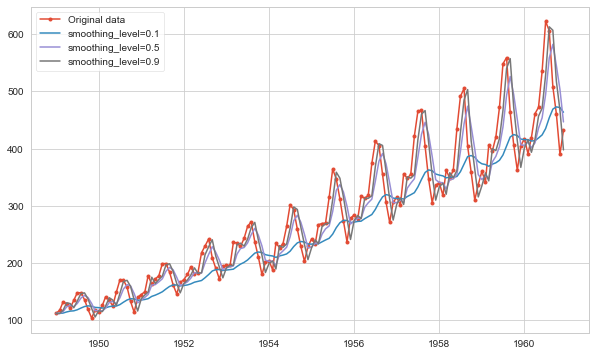

In [31]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

# Note the smoothing_level is the alpha parameter in the formula
fit1 = SimpleExpSmoothing(np.asarray(passenger_data['#Passengers'])).fit(smoothing_level=0.1, optimized=False)
fit2 = SimpleExpSmoothing(np.asarray(passenger_data['#Passengers'])).fit(smoothing_level=0.5, optimized=False)
fit3 = SimpleExpSmoothing(np.asarray(passenger_data['#Passengers'])).fit(smoothing_level=0.9, optimized=False)

plt.figure(figsize=(10, 6))
plt.plot(x, y, '.-', label='Original data')
# fit1 gives very small weight (0.1) to the most recent value (most smooth)
plt.plot(x, fit1.fittedvalues, label='smoothing_level=0.1') 
plt.plot(x, fit2.fittedvalues, label='smoothing_level=0.5')
# fit3 gives large weight (0.9) to the most recent value (most bumpy)
plt.plot(x, fit3.fittedvalues, label='smoothing_level=0.9') 
plt.legend()
plt.show()